In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/suriya/dcu/Group-Project


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
from src.features.rssi_distance import extract_feature2, postproc_feature_dicts
from src.featutils import aggregate_features_from_folder

train_dir = "data/tc4tl_training_data_v1/tc4tl/data/train/"
train_key = pd.read_csv("data/tc4tl_training_data_v1/tc4tl/docs/tc4tl_train_key.tsv", sep="\t")
test_dir = "data/tc4tl_data_v5/tc4tl/data/test/"
test_mdata = pd.read_csv("data/tc4tl_data_v5/tc4tl/docs/tc4tl_test_metadata.tsv", sep="\t")
test_key = pd.read_csv("data/tc4tl_test_key/tc4tl/docs/tc4tl_test_key.tsv", sep="\t")

In [ ]:
trainset, _ = aggregate_features_from_folder(train_dir, train_key, feat_fn=extract_feature2, postproc_fn=postproc_feature_dicts, verbose=True)
testset, _  = aggregate_features_from_folder(test_dir, test_key, feat_fn=extract_feature2, postproc_fn=postproc_feature_dicts, verbose=True)

# Friis Model

![](https://user-images.githubusercontent.com/9583894/139196420-3c739807-3741-4cff-945e-7218dc754494.png)

In [ ]:
def friis_model(Pt_dBm, Gt_dBi, Gr_dBi, f, d, L, n):
    _lambda = 3 * np.power(10, 8) / f
    PL_dB = Gt_dBi + Gr_dBi + 20 * np.log10(_lambda / (4. * np.pi)) - (10 * n * np.log10(d)) - (10. * np.log10(L))
    Pr_dBm = Pt_dBm + PL_dB
    return Pr_dBm, PL_dB

In [ ]:
def inverted_friis_model(rssi, Pt_dBm=0., Gt_dBi=1., Gr_dBi=1., f=2.4e9, L=1., n=2.):
    _lambda = 3 * np.power(10, 8) / f
    PL_dB = rssi - Pt_dBm
    return np.power(10, (Gt_dBi + Gr_dBi - PL_dB + 20 * np.log10(_lambda / (4. * np.pi)) - (10. * np.log10(L))) / (10 * n))

In [ ]:
d = np.linspace(0.1, 32, 100) # np.power(2, np.arange(0, 6))
# 2.4 GHz
Pr_dBm, PL_dB = friis_model(-40., 1., 1., 2.4e9, d, 1., 2)
# 5 GHz
Pr_dBm1, PL_dB1 = friis_model(-40., 1., 1., 5e9, d, 1., 2)

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(d, Pr_dBm, c='blue', label="2.4 GHz");
plt.plot(d, Pr_dBm1, c='red', label="5 GHz")
plt.xlabel("Distance (m)")
plt.ylabel("RSSI (dB)");

In [ ]:
plt.plot(d, Pr_dBm, label="Friis Free Space Model")
plt.scatter(d, Pr_dBm)
plt.plot(np.linspace(0.1, 32, 100), Pr_dBm_shadow, label="Log-normal Shadow Model")
plt.legend();

# Log-normal Shadowing Model

In [ ]:
def log_normal_shadowing_model(Pt_dBm, Gt_dBi, Gr_dBi, f, d0, d, L, sigma, n):
    _lambda = 3 * np.power(10, 8) / f
    K = 20 * np.log10(_lambda / (4 * np.pi)) - (10 * n * np.log10(d0)) - (10 * np.log10(L))
    X = sigma * np.random.randn(len(d))
    PL = Gt_dBi + Gr_dBi + K - (10 * n * np.log10(d/d0)) -X
    Pr_dBm = Pt_dBm + PL
    return Pr_dBm

Pr_dBm_shadow = log_normal_shadowing_model(
    Pt_dBm=-40., Gt_dBi=1., Gr_dBi=1., f=2.4e9, d0=1., d=np.linspace(0.1, 32, 100), L=1., sigma=2., n=2)

plt.figure(figsize=(8, 5))
plt.plot(np.linspace(0.1, 32, 100), Pr_dBm_shadow, alpha=0.5, label="Log-normal Shadow Model")
plt.scatter(np.linspace(0.1, 32, 100), Pr_dBm_shadow, alpha=0.5, s=25)
plt.xlabel("Distance (m)")
plt.ylabel("RSSI (dB)")
plt.legend();

In [ ]:
def inverted_log_normal_shadowing_model(rssi, Pt_dBm=0., Gt_dBi=1., Gr_dBi=1., f=2.4e9, d0=1., L=1., sigma=2., n=2.):
    _lambda = 3 * np.power(10, 8) / f
    K = 20 * np.log10(_lambda / (4 * np.pi)) - (10 * n * np.log10(d0)) - (10 * np.log10(L))
    X = sigma * np.random.randn(len(rssi))
    PL = rssi - Pt_dBm
    d = d0 * np.power(10, (Gt_dBi + Gr_dBi + K - PL)/(10 * n))
    return d

dpred = inverted_log_normal_shadowing_model(Pr_dBm_shadow, Pt_dBm=-40.)
plt.figure(figsize=(8, 5))
plt.plot(dpred, Pr_dBm_shadow, alpha=0.5, label="Log-normal Shadowing Model")
plt.scatter(dpred, Pr_dBm_shadow, alpha=0.5, s=25)
plt.xlabel("Distance (m)")
plt.ylabel("RSSI (dB)")
plt.legend();

In [ ]:
train_key[train_key.fileid == "aaadbuvp_tc4tl20.csv"]

In [ ]:
from src.features.common import read_bluetooth_from_file
import seaborn as sns

fp = "data/tc4tl_training_data_v1/tc4tl/data/train/aaadbuvp_tc4tl20.csv"
rssi = np.array(read_bluetooth_from_file(fp))
distance_estimates = inverted_log_normal_shadowing_model(rssi, Pt_dBm=-15)

plt.figure(figsize=(8, 4))
sns.distplot(distance_estimates);
plt.xlim(0, 5)

In [ ]:
np.median(distance_estimates)

In [ ]:
def lnsm(rssi, Pt_dBm=0., Gt_dBi=1., Gr_dBi=1., f=2.4e9, d0=1., L=1., sigma=2., n=2.):
    if isinstance(rssi, type([6, 9])):
        rssi = np.array(rssi)
    _lambda = 3 * np.power(10, 8) / f
    K = 20 * np.log10(_lambda / (4 * np.pi)) - (10 * n * np.log10(d0)) - (10 * np.log10(L))
    PL = rssi - Pt_dBm
    d = d0 * np.power(10, (Gt_dBi + Gr_dBi + K - PL)/(10 * n))
    return d

lnsm(rssi)

In [ ]:
from hyperopt import hp, fmin, tpe

# f: (2402 MHz to 2480 MHz)
# n: 1.5 to 5
def evaluate(params):
    distances = lnsm(rssi, Pt_dBm=params['Pt'], Gt_dBi=['Gt'], Gr_dBi=['Gr'],
                                       f=params['f'], d0=params['d0'], L=params['L'], n=params['n'])
    return abs(np.median(distances) - 1.8)

best = fmin(fn=evaluate,
    space={
        "Pt" : hp.uniform('Pt', -60., 20.),
        "Gt" : hp.uniform('Gt', 0.5, 2.5),
        "Gr" : hp.uniform('Gr', 0.5, 2.5),
        "f"  : hp.uniform("f", 2.402e9, 2.48e9),
        "d0" : hp.uniform("d0", 0.1, 2.),
        "L"  : hp.uniform("L", 1., 2),
        "n"  : hp.uniform("n", 1., 5)
    },
    algo=rand.suggest,
    max_evals=100)

In [ ]:
def eval_min_params(params):
    Pt, n = params
    d = lnsm(rssi, Pt_dBm=Pt, n=n)
    return abs(np.median(d) - 2.1)

In [ ]:
from scipy import optimize


result = optimize.fmin(eval_min_params, [20., 2.])

In [ ]:
result

In [ ]:
distance_estimates = inverted_log_normal_shadowing_model(rssi, Pt_dBm=-11., n=4.68273821)
sns.distplot(distance_estimates)

In [ ]:
plt.hist(distance_estimates, density=True)

In [ ]:
train_key.distance_in_meters.unique()

In [ ]:
1.2 + (3-1.2)/2

## Flat-Earth Model

![](https://user-images.githubusercontent.com/9583894/139525199-53d4d641-b885-4308-98ba-79b70806c975.png)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
def flat_earth_model(d, P_t=-30., G_r=1, G_t=1, h1=1, h2=1, p=0.9):
    # Gt_dBi + Gr_dBi + 20 * np.log10(_lambda / (4. * np.pi)) - (10 * n * np.log10(d)) - (10. * np.log10(L))
    return Pr
    

In [ ]:
d = np.linspace(0.1, 7, 100)
rssi = flat_earth_model(d)

plt.figure(figsize=(8, 5))
plt.plot(d, rssi, alpha=0.8);

## Generate Features

In [11]:
import seaborn as sns

In [5]:
key = train_key[train_key.fileid=='aabqtowt_tc4tl20.csv'].reset_index().loc[0]
key.fileid

'aabqtowt_tc4tl20.csv'

In [9]:
from src.features.radioprop import extract_features

tunables = {
        "LinearApprox": {"TX": -61.02, "N": 2.187},
        "Friis": dict(Pt_dBm=0., Gt_dBi=1., Gr_dBi=1., f=2.4e9, L=1., n=2.),
        "LogNormal": dict(Pt_dBm=-20., Gt_dBi=1., Gr_dBi=1.,
                          f=2.4e9, d0=1., L=1., sigma=2., n=2)
    }
feats = extract_features("data/tc4tl_training_data_v1/tc4tl/data/train/aabqtowt_tc4tl20.csv", key, tunables=tunables)

In [10]:
feats

{'LinearApprox': array([ 0.47754285,  0.42982098,  0.42982098,  0.42982098,  0.42982098,
         0.42982098,  0.34820751,  0.34820751,  0.47754285,  0.47754285,
         0.42982098,  0.42982098,  0.34820751,  0.34820751,  0.47754285,
         0.47754285,  0.42982098,  0.42982098,  0.3134104 ,  0.3134104 ,
         0.42982098,  0.42982098,  0.47754285,  0.47754285,  0.34820751,
         0.34820751,  0.47754285,  0.47754285,  0.53056315,  0.53056315,
         0.38686806,  0.38686806,  0.58947015,  0.58947015,  0.53056315,
         0.53056315,  0.65491744,  0.65491744,  0.58947015,  0.58947015,
         0.38686806,  0.38686806,  0.47754285,  0.47754285,  0.42982098,
         0.47754285,  0.34820751,  0.34820751,  0.53056315,  0.53056315,
         0.53056315,  0.38686806,  0.38686806,  0.53056315,  0.53056315,
         0.47754285,  0.47754285,  0.38686806,  0.38686806,  0.53056315,
         0.53056315,  0.53056315,  0.53056315,  0.47754285,  0.47754285,
         0.38686806,  0.38686806,  

<Figure size 720x432 with 0 Axes>

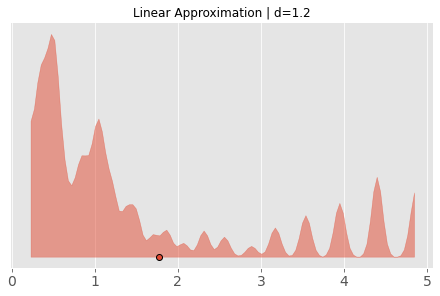

<Figure size 720x432 with 0 Axes>

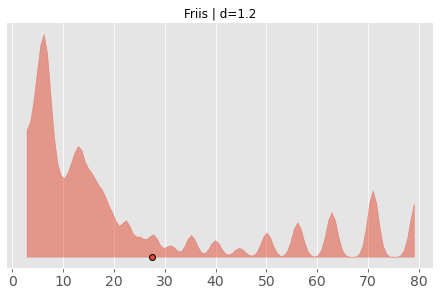

<Figure size 720x432 with 0 Axes>

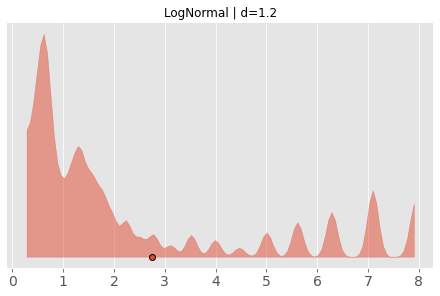

In [34]:
import arviz as az

plt.figure(figsize=(10, 6))
az.plot_density(feats["LinearApprox"],outline=False, shade=.5, bw=0.9);
plt.title(f"Linear Approximation | d={key.distance_in_meters}", fontsize=12);
plt.figure(figsize=(10, 6))
az.plot_density(feats["Friis"],outline=False, shade=.5, bw=0.9);
plt.title(f"Friis | d={key.distance_in_meters}", fontsize=12);
plt.figure(figsize=(10, 6))
az.plot_density(feats["LogNormal"],outline=False, shade=.5, bw=0.9);
plt.title(f"LogNormal | d={key.distance_in_meters}", fontsize=12);

<Figure size 576x360 with 0 Axes>

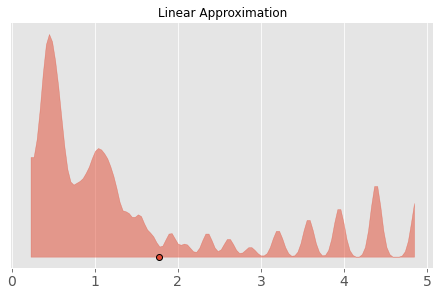

In [38]:
from src.viz import plot_density

plot_density(feats["LinearApprox"], title="Linear Approximation")

## Global Parameter Search

In [39]:
mitre = pd.read_csv("data/processed/MITRE-range_angle_structured.Bluetooth.csv")
matrix= pd.read_csv("data/processed/MIT-Matrix-Data.Bluetooth.csv")

In [42]:
mitre.Range.unique(), matrix.Range.unique()

(array([10.,  5.,  6.,  4.,  3., 12.,  8., 15.,  9.]),
 array([ 5.,  4., 10., 15.,  8.,  3., 12.,  6.]))

<Figure size 576x360 with 0 Axes>

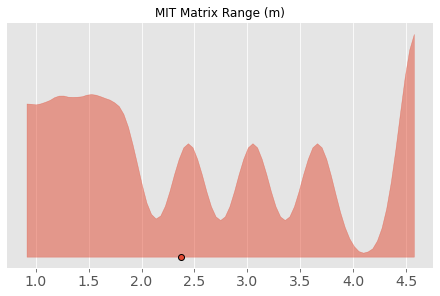

In [55]:
matrix["RangeInMeters"] = matrix.Range / 3.281
plot_density(matrix["RangeInMeters"].values, title="MIT Matrix Range (m)", bw=2.)

<Figure size 576x360 with 0 Axes>

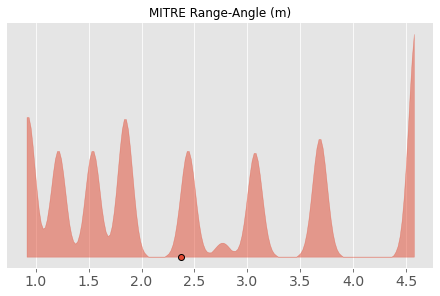

In [56]:
mitre["RangeInMeters"] = mitre.Range / 3.281
plot_density(mitre["RangeInMeters"].values, title="MITRE Range-Angle (m)", bw=2.)

In [60]:
data = pd.concat([mitre, matrix]).reset_index()

<Figure size 720x504 with 0 Axes>

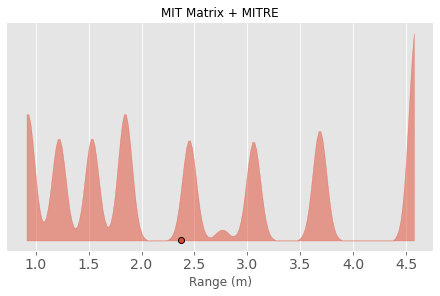

In [73]:
plot_density(data.RangeInMeters.values, bw=2., title="MIT Matrix + MITRE", xlabel="Range (m)")
plt.xlabel("Range (m)");

## Evaluate Best Params for LAM

In [78]:
from src.features.radioprop import (inverted_friis_free_space_model, 
                                    inverted_log_normal_shadowing_model, linear_approximation_model)
from src.features.common import read_bluetooth_from_file

In [118]:
from scipy import optimize

#rssi = np.array(
#    read_bluetooth_from_file("data/tc4tl_training_data_v1/tc4tl/data/train/aaadbuvp_tc4tl20.csv"))

def eval_min_params(params):
    P_t, n = params
    mse = []
    for ix, row in data.iterrows():
        rssi = np.array([ float(b.strip()) for b in row.Bluetooth[1:-1].split(',') ])
        d = row.RangeInMeters
        dpred = linear_approximation_model(rssi, P_t, n)
        mse.append((d - np.median(dpred))**2)
    return np.array(mse).mean()

In [222]:
lam_best_params = optimize.minimize(eval_min_params, [-40., 1.], bounds=[(-70., 20.), (0.5, 7)])
lam_best_params.x

array([-45.27892726,   7.        ])

## Evaluate best params of Friis

In [138]:
# rssi, Pt_dBm=0., Gt_dBi=1., Gr_dBi=1., f=2.4e9, L=1., n=2.):
# 2402-2480
def eval_friis(params):
    Pt_dBm, L, n = params
    mse = []
    for ix, row in data.iterrows():
        rssi = np.array([ float(b.strip()) for b in row.Bluetooth[1:-1].split(',') ])
        d = row.RangeInMeters
        dpred = inverted_friis_free_space_model(rssi, Pt_dBm=Pt_dBm, n=n, L=L)
        mse.append((d - np.median(dpred))**2)
    return np.array(mse).mean()

In [139]:
best = optimize.minimize(eval_friis, [0., 1., 2.], bounds=[(-60, 20), (0.1, 2.), (0.5, 7)], method='TNC', tol=1e-10)
best

     fun: 1.4821244169496717
     jac: array([ 2.22044605e-07, -8.65973959e-07, -9.43364276e-02])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 68
     nit: 14
  status: 1
 success: True
       x: array([-6.97565526,  1.06102343,  7.        ])

In [249]:
linear_approximation_model

<function src.features.radioprop.linear_approximation_model(rssi, TX=-61.02, N=2.187)>

In [250]:
inverted_friis_free_space_model

<function src.features.radioprop.inverted_friis_free_space_model(rssi, Pt_dBm=0.0, Gt_dBi=1.0, Gr_dBi=1.0, f=2400000000.0, L=1.0, n=2.0)>

<Figure size 720x504 with 0 Axes>

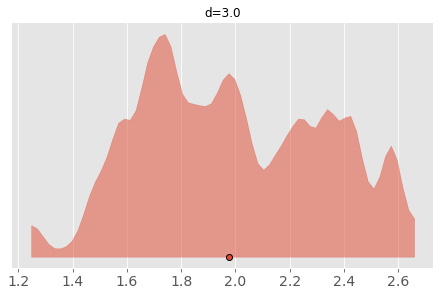

<Figure size 720x504 with 0 Axes>

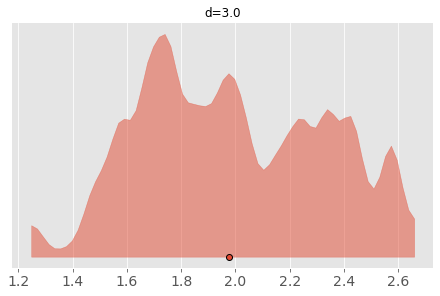

In [260]:
filename = test_key.fileid.sample().item()
rssi = np.array(
    read_bluetooth_from_file(f"data/tc4tl_data_v5/tc4tl/data/test/{filename}"))
dreal = test_key[test_key.fileid==filename].reset_index().loc[0].distance_in_meters
dpred = inverted_friis_free_space_model(rssi, Pt_dBm=best.x[0], L=best.x[1], n=best.x[2])
dpred_lam = linear_approximation_model(rssi, lam_best_params.x[0], lam_best_params.x[1])
plot_density(dpred, title=f"d={dreal}")
plot_density(dpred_lam, title=f"d={dreal}")

<Figure size 720x504 with 0 Axes>

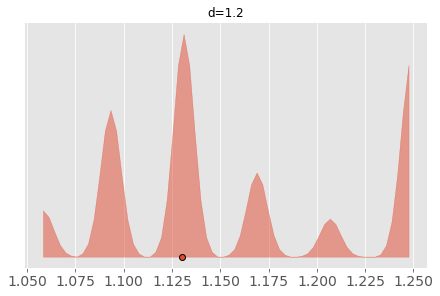

In [237]:
filename = test_key.fileid.sample().item()
rssi = np.array(
    read_bluetooth_from_file(f"data/tc4tl_data_v5/tc4tl/data/test/{filename}"))
dreal = test_key[test_key.fileid==filename].reset_index().loc[0].distance_in_meters
dpred = linear_approximation_model(rssi, lam_best_params.x[0], lam_best_params.x[1])
plot_density(dpred, title=f"d={dreal}")

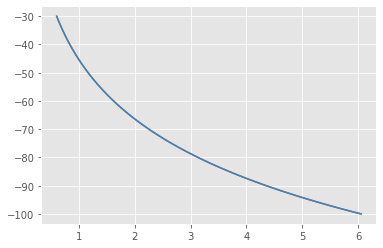

In [264]:
rssi = np.linspace(-100, -30, 100)
dfriis = inverted_friis_free_space_model(rssi, Pt_dBm=best.x[0], L=best.x[1], n=best.x[2])
dlam = linear_approximation_model(rssi, lam_best_params.x[0], lam_best_params.x[1])
plt.plot(dfriis, rssi)
plt.plot(dlam, rssi)

In [261]:
best.x

array([-6.97565526,  1.06102343,  7.        ])

In [262]:
lam_best_params.x

array([-45.27892726,   7.        ])